In [285]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

In [286]:
df = pd.read_csv('./COEBiddingResultsPrices.csv', parse_dates=['month'])

In [287]:
df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
0,2010-01-01,1,Category A,1152,1145,1342,18502
1,2010-01-01,1,Category B,687,679,883,19190
2,2010-01-01,1,Category C,173,173,265,19001
3,2010-01-01,1,Category D,373,365,509,889
4,2010-01-01,1,Category E,586,567,1011,19889


In [288]:
# extract all vehicle classes for individual model training
vehicle_class = df.vehicle_class.unique().tolist()

# Treat all vehicle classes as one to quickly find the optimal PCA components

In [289]:
# sort by month and bidding_no
df = df.sort_values(['month', 'bidding_no'])

In [290]:
# clean up numerical cols
num_cols = ['quota', 'bids_received', 'bids_success', 'premium']
for col in num_cols:
    df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)

In [291]:
# feature engineerings to include lags and moving average, to predict based on quota, bids_received(t-1), bids_success(t-1), premium(t-1)
# and their moving averages
def create_features(df, lag=1, ma_windows=[3, 6, 9, 12], mode='training'):
    df = df.copy()
    for col in ['bids_received', 'bids_success', 'premium']:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    for col in ['quota','bids_received_lag_1', 'bids_success_lag_1', 'premium_lag_1']:
        for window in ma_windows:
            df[f'{col}_ma{window}'] = df[col].rolling(window).mean()
    if mode == 'training':
        return df.dropna()
    else:
        return df
    

df = create_features(df)

In [292]:
df.head()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium,bids_received_lag_1,bids_success_lag_1,premium_lag_1,...,bids_received_lag_1_ma9,bids_received_lag_1_ma12,bids_success_lag_1_ma3,bids_success_lag_1_ma6,bids_success_lag_1_ma9,bids_success_lag_1_ma12,premium_lag_1_ma3,premium_lag_1_ma6,premium_lag_1_ma9,premium_lag_1_ma12
12,2010-02-01,1,Category C,165.0,162.0,250.0,21390.0,930.0,690.0,23180.0,...,967.444444,933.083333,807.333333,615.000000,641.222222,647.333333,21689.333333,18068.333333,16632.111111,17198.500000
13,2010-02-01,1,Category D,371.0,349.0,525.0,852.0,250.0,162.0,21390.0,...,938.666667,842.083333,668.333333,522.500000,618.666667,565.416667,21519.666667,17900.000000,18910.000000,17439.166667
14,2010-02-01,1,Category E,601.0,596.0,1069.0,22401.0,525.0,349.0,852.0,...,884.666667,812.250000,400.333333,551.833333,594.444444,537.916667,15140.666667,14693.666667,16794.777778,15911.000000
15,2010-02-01,2,Category A,1148.0,1148.0,1493.0,20340.0,1069.0,596.0,22401.0,...,817.555556,879.250000,369.000000,588.166667,533.000000,573.166667,14881.000000,18285.166667,17005.888889,16194.333333
16,2010-02-01,2,Category B,685.0,658.0,956.0,23889.0,1493.0,1148.0,20340.0,...,860.666667,961.250000,697.666667,683.000000,580.888889,638.416667,14531.000000,18025.333333,16777.000000,17815.250000


In [293]:
# prepare X and y
excluded_cols = ['month', 'bidding_no', 'vehicle_class', 'premium', 'bids_received', 'bids_success']
X = df[[col for col in df.columns if col not in excluded_cols]].copy()
y = df['premium'].copy()

In [294]:
# scale X and y
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

In [295]:

# Fit PCA with max components
pca = PCA()
pca.fit(X_scaled)

PCA()

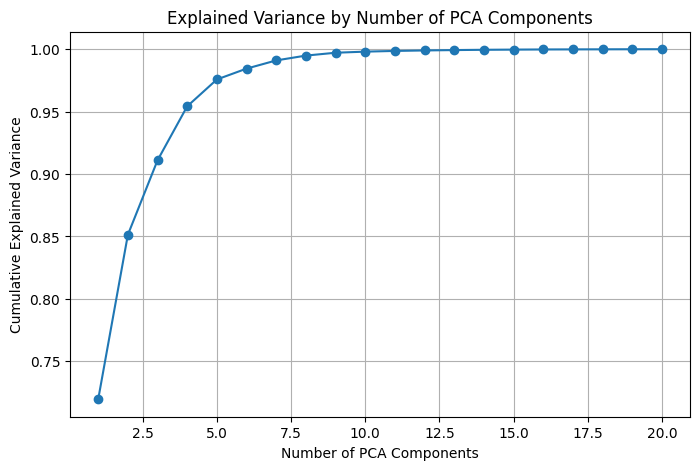

In [296]:
# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative variance vs number of components
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of PCA Components')
plt.grid(True)
plt.show()


In [297]:
# Find number of components to reach threshold (e.g. 95%)
variance_threshold = 0.95
optimal_components = (cumulative_variance >= variance_threshold).argmax() + 1
print(f"Number of components to retain {variance_threshold*100}% variance: {optimal_components}")

Number of components to retain 95.0% variance: 4


# Traing model for each individual vehicle class

In [298]:
# look back half a year
time_steps = 12
# set optimal components = 4
pca_components = 4

In [299]:
# Cceate sequences for LSTM 
def create_sequences(X, y, time_steps=time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])  # target is the next step after the sequence
    return np.array(X_seq), np.array(y_seq)

# train model
def train_model(df, v_class):
    print(f"Traing for: {v_class}")

    df = df[df.vehicle_class == v_class].copy()

    df = create_features(df)
    
    X = df[[col for col in df.columns if col not in excluded_cols]].copy()
    y = df['premium'].copy()

    # scale X and y
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    # y_scaled = y.values.reshape(-1,1)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

    # fit PCA with optimal number of components
    # print (len(X.columns))
    pca = PCA(n_components=pca_components)  # pick number of components or variance threshold
    X_pca = pca.fit_transform(X_scaled)
    # print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

    split_idx = int(len(X_pca) * 0.8) 

    X_train_raw, X_test_raw = X_pca[:split_idx], X_pca[split_idx:]
    y_train_raw, y_test_raw = y_scaled[:split_idx], y_scaled[split_idx:]

    X_train, y_train = create_sequences(X_train_raw, y_train_raw, time_steps)
    X_test, y_test = create_sequences(X_test_raw, y_test_raw, time_steps)

    model = Sequential()
    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mse')

    model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print(f"MSE: {mse:.4f}")
    
    # save the model
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=[keras.metrics.MeanAbsoluteError()])
    model.save('./models/{}_lstm.h5'.format(v_class))

In [300]:
# reimport df and clean data
df = pd.read_csv('./COEBiddingResultsPrices.csv', parse_dates=['month'])

df = df.sort_values(['month', 'bidding_no'])

for col in num_cols:
    df[col] = df[col].astype(str).str.replace(r'[^\d.]', '', regex=True).astype(float)


for v_class in vehicle_class:
    train_model(df, v_class)

Traing for: Category A
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


MSE: 0.1395
Traing for: Category B
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


MSE: 0.0451
Traing for: Category C
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


MSE: 0.0206
Traing for: Category D
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


MSE: 0.0124
Traing for: Category E
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


MSE: 0.0111


# Make recommendation for each vehicle class via sensivity analysis
Assuming bids received and succeed as the mean of the past 10 transactions, and a stable price means that the next price is close to the previous price

In [301]:
# create a new row for prediction
def create_next_row(df, quota_value):
    # Copy df to avoid inplace edits
    df_ext = df.copy()
     
    # Initialize new row with NaNs
    df_ext.loc[len(df_ext)] = pd.Series()
    
    # Set Quota
    df_ext.loc[len(df_ext)-1, 'quota'] = quota_value

    # Recompute engineered features for the entire df_ext, especially the new row
    df_ext = create_features(df_ext, mode = 'testing')

    # print(df_ext.iloc[-1])
    
    return df_ext

In [ ]:
def make_recommendation(df, model, v_class):
    # Parameters
    time_steps = 10
    latest_price = df['premium'].iloc[-1]

    # Define quota range to test (e.g., ±20% around latest quota)
    quota_current = df['quota'].iloc[-1]
    quota_range = np.linspace(quota_current * 0.8, quota_current * 1.2, 40)

    predicted_prices = []
    price_diffs = []

    for q in quota_range:
        df_new = create_next_row(df, q)

        df_new = df_new[[col for col in df_new.columns if col not in excluded_cols + ['index']]].copy()
        
        # Extract last time_steps rows (including the new row) for model input
        input_seq_df = df_new.tail(time_steps)
        
        # Scale and PCA transform
        scaler_X = MinMaxScaler()
        scaled = scaler_X.fit_transform(input_seq_df)
        pca = PCA(n_components=pca_components) 
        pca_features = pca.fit_transform(scaled)
        
        # Reshape for LSTM input: (1, time_steps, n_features)
        input_seq = np.expand_dims(pca_features, axis=0)
    
        
        # Predict next COE price
        pred_scaled = model.predict(input_seq)
        # pred_price = pred_scaled[0][0]
        pred_price = scaler_y.inverse_transform(pred_scaled)[0][0]
        
        predicted_prices.append(pred_price)
        price_diffs.append(abs(pred_price - latest_price))

    # Find optimal quota minimizing price deviation
    if price_diffs:
        min_idx = np.argmin(price_diffs)
        optimal_quota = quota_range[min_idx]
        optimal_price = predicted_prices[min_idx]
        
        print(f"Vehicle Class: {v_class}")
        print(f"\t Latest COE price: {latest_price:.2f}")
        print(f"\t Recommended next quota: {optimal_quota:.0f} to stabilize predicted price at approx {optimal_price:.2f}")
    else:
        print("No valid quota candidate due to NaNs in features.")

In [303]:
df.tail()

,month,bidding_no,vehicle_class,quota,bids_success,bids_received,premium
1830,2025-07-01,1,Category A,1253.0,1250.0,1918.0,101102.0
1831,2025-07-01,1,Category B,781.0,781.0,1199.0,119600.0
1832,2025-07-01,1,Category C,291.0,275.0,432.0,66689.0
1833,2025-07-01,1,Category D,533.0,533.0,629.0,9389.0
1834,2025-07-01,1,Category E,212.0,207.0,384.0,118500.0


In [304]:
import warnings
warnings.filterwarnings('ignore')

In [305]:
from tensorflow.keras.models import load_model
for v_class in vehicle_class:
    model = load_model('./models/{}_lstm.h5'.format(v_class))
    input_df = df[df.vehicle_class == v_class].reset_index().copy()
    make_recommendation(input_df, model, v_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

Vehicle Class: Category B
	 Latest COE price: 119600.00
	 Recommended next quota: 937 to stabilize predicted price at approx 0.32
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/s

Vehicle Class: Category C
	 Latest COE price: 66689.00
	 Recommended next quota: 272 to stabilize predicted price at approx 0.54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/st

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

In [221]:
df.tail

<bound method NDFrame.tail of           month  bidding_no vehicle_class   quota  bids_success  \
0    2010-01-01         1.0    Category A  1152.0        1145.0   
1    2010-01-01         1.0    Category B   687.0         679.0   
2    2010-01-01         1.0    Category C   173.0         173.0   
3    2010-01-01         1.0    Category D   373.0         365.0   
4    2010-01-01         1.0    Category E   586.0         567.0   
...         ...         ...           ...     ...           ...   
1831 2025-07-01         1.0    Category B   781.0         781.0   
1832 2025-07-01         1.0    Category C   291.0         275.0   
1833 2025-07-01         1.0    Category D   533.0         533.0   
1834 2025-07-01         1.0    Category E   212.0         207.0   
1835        NaT         NaN           NaN    20.0           NaN   

      bids_received   premium  
0            1342.0   18502.0  
1             883.0   19190.0  
2             265.0   19001.0  
3             509.0     889.0  
4    